In [116]:
import numpy as np
# Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
import mnist_loader

import matplotlib.pyplot as plt
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()



In [117]:
training_data_segment = list(training_data)[10:200]
unlabeled_data = np.array([data[0] for data in training_data_segment])
data = unlabeled_data.T.reshape(784,-1) # each example stored in a column

In [118]:
import warnings
warnings.simplefilter('error', RuntimeWarning)

In [121]:
def sigmoid(x):
#     print('max of x array is ' + str(np.amax(x)))
#     print('min of x is ' + str(np.amin(x)))
    return 1/(1+np.exp(-x))

def sp(sigma):
	return sigma*(1-sigma)


def feedforward(x, w, b):  # Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
    # x should have examples in columns!
    a_hidden = sigmoid(np.dot(w,x)+b[0])
    a_out = sigmoid(np.dot(w.transpose(),a_hidden)+b[1])
    return [a_hidden, a_out] # Examples are still stored in columns in the hidden layer
# B's will work, I just need to be careful when I recreate images.

def backprop(x, w, b):
    a_hidden, a_out = feedforward(x,w,b)
    d_out = (a_out-x)*sp(a_out) # Using quad-cost for now
    d_hidden = np.dot(w,d_out)*sp(a_hidden)

    #dW_jk = a_k_l-1 * d_j
    dC_dw_T = np.dot(d_out, a_hidden.transpose())
    dC_dw_input = np.dot(d_hidden, x.transpose())

    dC_dw = dC_dw_input+dC_dw_T.transpose()
    dC_db = [np.sum(d_hidden, axis = 1).reshape(b[0].shape), np.sum(d_out, axis = 1).reshape(b[1].shape)] # put these in cells of a matrix
    return dC_dw, dC_db


def backpropsparse(x,w,b,rho,beta):
    a_hidden, a_out = feedforward(x,w,b)
    rho_hat = np.sum(a_hidden, axis = 1).reshape(len(a_hidden),1)/x.shape[1] # I'm pretty sure the dimension
    # I think I'm not averaging!!! YIKES! Dang it. I needed to divide by x.shape[1] (the # of egs!)
    KL_deriv = (beta*(-(rho/rho_hat)+((1-rho)/(1-rho_hat)))).reshape(len(a_hidden),1)
    d_out = (a_out-x)*sp(a_out)
#     KL_deriv = np.matrix(KL_deriv)


    d_hidden = (np.dot(w,d_out)+KL_deriv)*sp(a_hidden)
#     d_hidden = (np.dot(w,d_out))+KL_deriv
#     d_hidden = np.multiply(d_hidden,sp(a_hidden))


    #dW_jk = a_k_l-1 * d_j
    dC_dw_T = np.dot(d_out, a_hidden.transpose())
    dC_dw_input = np.dot(d_hidden, x.transpose())

    dC_dw = dC_dw_input+dC_dw_T.transpose()
    dC_db = [np.sum(d_hidden, axis = 1).reshape(b[0].shape), np.sum(d_out, axis = 1).reshape(b[1].shape)] # put these in cells of a matrix
    return dC_dw, dC_db, rho_hat

def update_net(x,w,b,rho = 0, beta = 0, sparse = 0):
    if sparse:
        dC_dw, dC_db, rho_hat = backpropsparse(x, w, b,rho,beta)
    else:
        dC_dw, dC_db = backprop(x, w, b)
        rho_hat = [0,0]
    # Using gradient descent
    w = w - dC_dw/x.shape[1]
    b[0] = b[0] - dC_db[0]/x.shape[1]
    b[1] = b[1] - dC_db[1]/x.shape[1]
    return w,b,rho_hat

def eval_err(data,w,b):
    prediction = feedforward(data,w,b)
    error = sum(sum((prediction[1] - data)**2))/(len(data))
    return error

# use this guy if not including sparcity term
def Grad_descent(data,w,b,iterations,sparse):
    for i in range(iterations):
        w,b = update_net(data,w,b)
        
        if i%499 == 0:
            print(eval_err(data,w,b))
    return w,b
        
def Grad_descent_sparse(data,w,b,iterations,sparse,rho = 0,beta = 0):
    rho_hat_avg = []
    for i in range(iterations):
        w,b,rho_hat = update_net(data,w,b,rho,beta,sparse)
        rho_hat_avg.append(sum(rho_hat)/len(rho_hat))
        if i%50 == 0:
            print(eval_err(data,w,b))    
    
    return w,b,rho_hat_avg,rho_hat



In [122]:
hidden_size = 2000
sizes = [784,hidden_size,784]
b= [np.zeros((hidden_size,1)), np.zeros((784,1))]
w = np.random.randn(sizes[1],sizes[0])/np.sqrt(sizes[0])
rho = 0.05
beta = 0
# for i in range(1000):
#     w,b = update_net(data,w,b,rho,beta)

#     if i%499 == 0:
#         print(eval_err(data,w,b))
w,b,rho_hat_avg,rho_hat = Grad_descent_sparse(data,w,b,400,sparse = 0,rho = 0.3 ,beta = 1)
# This means it's not 
# w,b = Grad_descent(data,w,b,200,0)


# for the overflow, l think what's happening is that the weights are growing too quickly, and the x grows large therefore
# The reason adding more examples is bad is that the weights change quicker bc i have!
# That was totally the reason! It's fixed now!



18.5436118563
6.62171944407
3.49751100483
2.20617931268
1.60600936354
1.26480869884
1.06590044701
0.930300602682


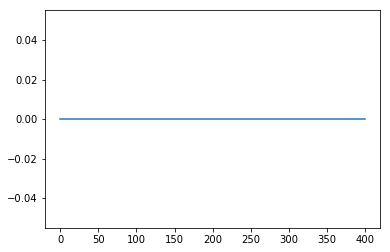

In [123]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(len(rho_hat_avg)),rho_hat_avg)
plt.show()

# It's outputting just what I'd expect
# The equilibrium point is just above the ideal level (rho),
# because it wants to have higher weight values to decrease total error.


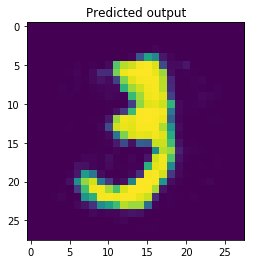

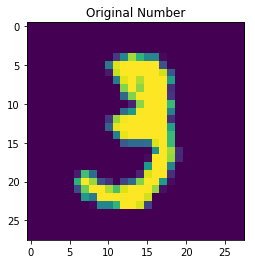

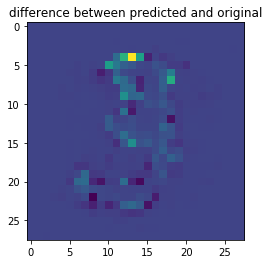

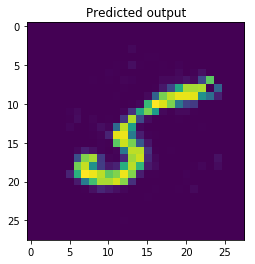

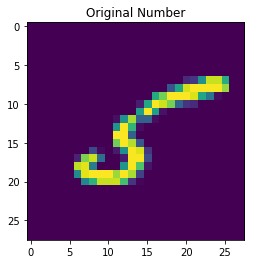

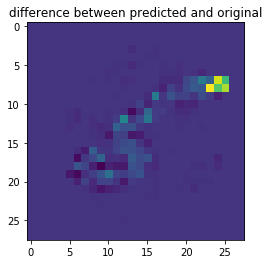

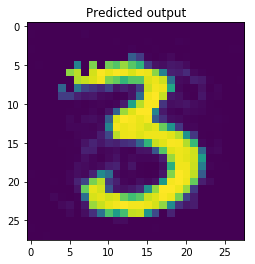

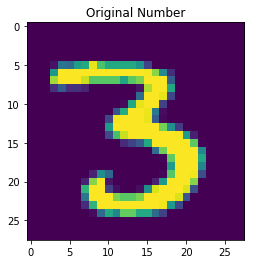

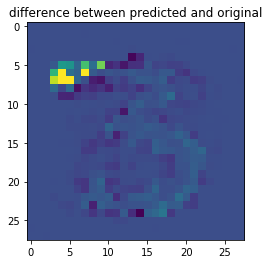

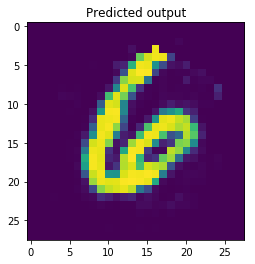

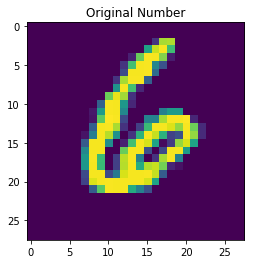

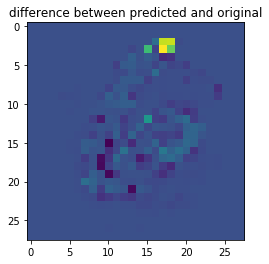

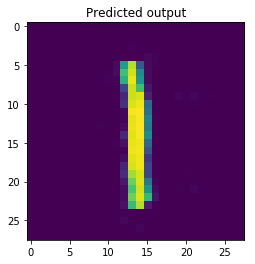

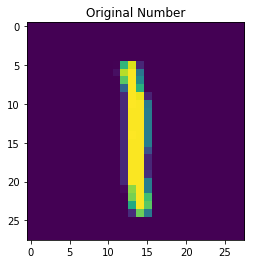

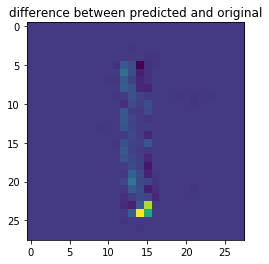

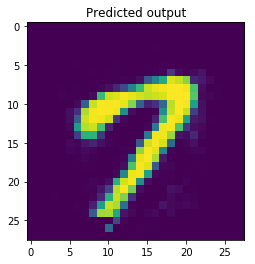

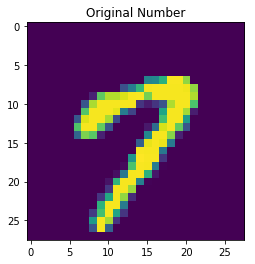

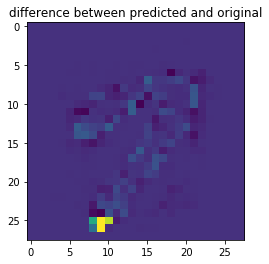

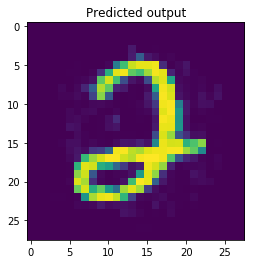

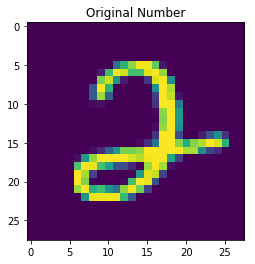

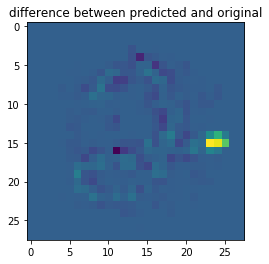

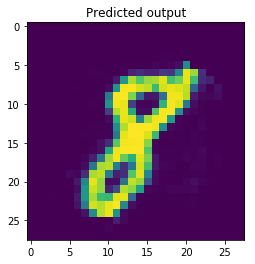

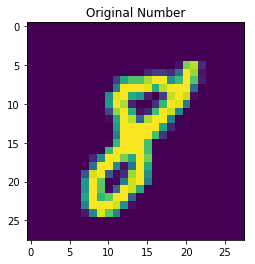

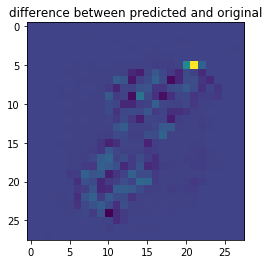

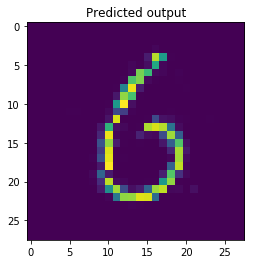

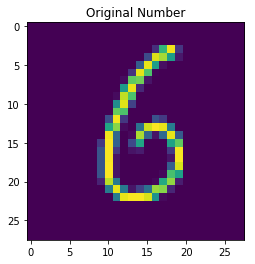

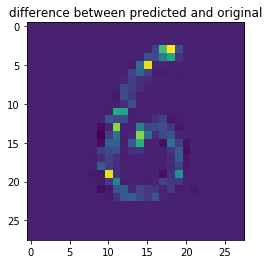

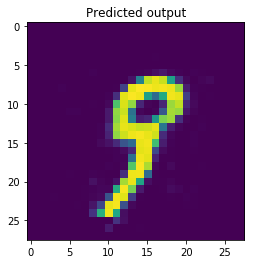

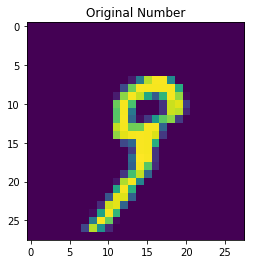

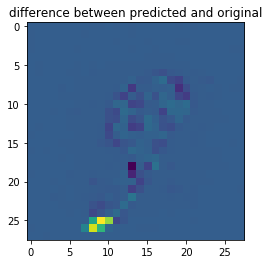

In [127]:
for digit in range(10):
    output = feedforward(data.T[digit].reshape(784,1),w,b) # Have to transpose becasue egs are in columns.
    # print(data.T[0].shape)
    output = np.array(output[1])
    # print(output.shape)

    plt.imshow(np.array(output).reshape(28,28))
    plt.title('Predicted output')
    plt.show()

    plt.figure()
    plt.imshow(np.array(data.T[digit].reshape(28,28)))
    plt.title('Original Number')
    plt.show()

    plt.figure()
    plt.imshow(np.array(data.T[digit].reshape(28,28))-np.array(output).reshape(28,28))
    plt.title('difference between predicted and original')
    plt.show()

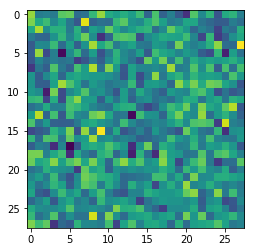

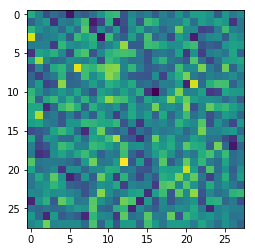

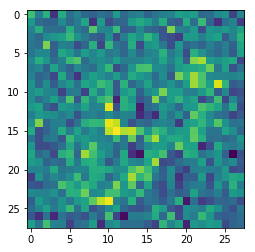

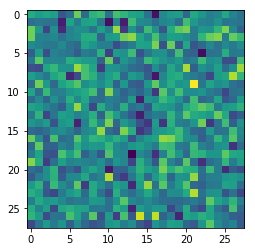

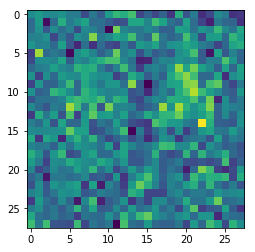

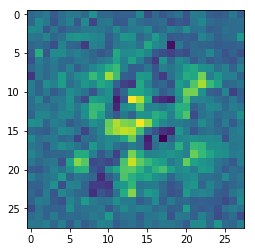

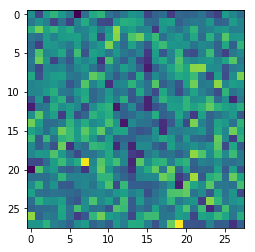

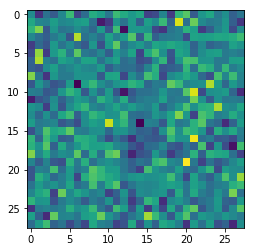

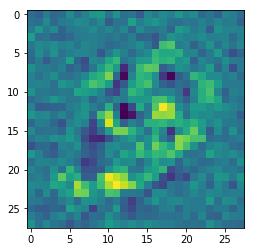

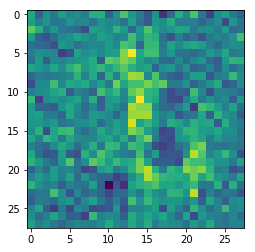

In [126]:
for row in w[::200]:
    plt.figure()
    plt.imshow(row.reshape(28,28), interpolation = 'nearest')
    plt.show()



# LEARNINGS FROM THE CODE

# Why sparcity wasn't working:
I didn't use the actual average activation for rho_hat, but just a sum! Big mistake

# exp OVERFLOW:
for the overflow, l think what's happening is that the weights are growing too quickly, and the x, which is the np.dot(w,x)+b grows large therefore you get overflow.
Initially it seemed something was wrong bc it would only overflow if there were a lot of training egs, but this wasn't the real reason.
The reason adding more examples is bad is that the weights change quicker bc i haven't yet normalized the gradient by the number of training examples. I didn't think I'd have to, since a full-batch gradient would be much more accurate than SGD or online approach. However, even if it is more accurate, I still needed to effectively slow down learning to allow the sparcity penalty (which acts as a sort of regularization) to dampen the w growth. If w just grows out of control at first, it gives exponential overflow!

That was totally the reason! It's fixed now! But I should include a learning rate term. 
I think L2 reg would have addressed this issue.


# Questions to think about
- What does sparsity achieve for your model?
I think it serves 2 purposes. 

A. It serves as a kind of regularization, similar to dropout, but not as abrupt? It means the classifier can't rely on any one hidden neuron too much. 

B. Every AE should have fewer hiddens working than the number of inputs, at least during training. I think expanding the number of hidden nodes beyond the input nodes can allow the AE to draw from 


- How would you interpret the ten weight images? What would happen to weight images if you had not 500 but 50 hidden nodes?
They become more like complete numbers.
- Since autoencoder is designed to reduce dimensionality of data, what are analogs among other dimensionality reduction algorithms? Can one design a linear model with the same properties? An SVM? How would you compare their performance?
- There are plenty image compression algorithms. How they are related to the autoencoder NN? What are their advantages/weaknesses? 
I think that’s enough for now -;).